In [2]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile
from qiskit_ibm_provider import IBMProvider
import qiskit_ibm_provider.jupyter
 
#provider = IBMProvider('ibm-q')
#backend = provider.get_backend('ibmq_vigo')
from qiskit.visualization import *
from ibm_quantum_widgets import *

# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum")

# Invoke a primitive. For more details see https://qiskit.org/documentation/partners/qiskit_ibm_runtime/tutorials.html
# result = Sampler("ibmq_qasm_simulator").run(circuits).result()

/opt/conda/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/opt/conda/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
qiskit_runtime_service.__init__:INFO:2024-03-15 10:06:39,474: Default instance: ibm-q/open/main


In [7]:
# Built-in modules
import math

# Imports from Qiskit
from qiskit import QuantumCircuit
from qiskit.circuit.library import GroverOperator, MCMT, ZGate
from qiskit.visualization import plot_distribution

# Imports from Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Session

In [8]:
from qiskit.circuit import QuantumCircuit, Gate, Instruction
from qiskit.circuit.library.standard_gates import ZGate

def MCMT(gate, num_controls, num_targets):
    """Construct a multi-controlled multi-target gate.

    Args:
        gate (Gate): The gate to apply to the target qubits.
        num_controls (int): The number of control qubits.
        num_targets (int): The number of target qubits.

    Returns:
        Instruction: The multi-controlled multi-target gate as a Qiskit Instruction.
    """
    mcmt_gate = QuantumCircuit(num_controls + num_targets)
    mcmt_gate.append(gate.control(num_controls), list(range(num_controls + num_targets)))
    return mcmt_gate.to_instruction()

In [15]:
def grover_oracle(marked_states):
    """Build a Grover oracle for multiple marked states

    Here we assume all input marked states have the same number of bits

    Parameters:
        marked_states (str or list): Marked states of oracle

    Returns:
        QuantumCircuit: Quantum circuit representing Grover oracle
    """
    if not isinstance(marked_states, list):
        marked_states = [marked_states]
    # Compute the number of qubits in circuit
    num_qubits = len(marked_states[0])

    qc = QuantumCircuit(num_qubits)
    # Mark each target state in the input list
    for target in marked_states:
        # Flip target bit-string to match Qiskit bit-ordering
        rev_target = target[::-1]
        # Find the indices of all the '0' elements in bit-string
        zero_inds = [ind for ind in range(num_qubits) if rev_target.startswith("0", ind)]
        # Add a multi-controlled Z-gate with pre- and post-applied X-gates (open-controls)
        # where the target bit-string has a '0' entry
        qc.x(zero_inds)
        #qc.ry(0.1,zero_inds)
        qc.compose(MCMT(ZGate(), num_qubits - 1, 1), inplace=True)
        qc.x(zero_inds)
    return qc

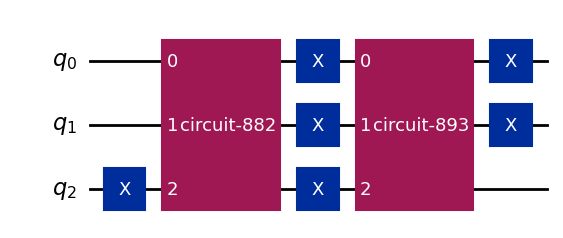

In [20]:
marked_states = ["011", "100"]

oracle = grover_oracle(marked_states)
oracle.draw("mpl")

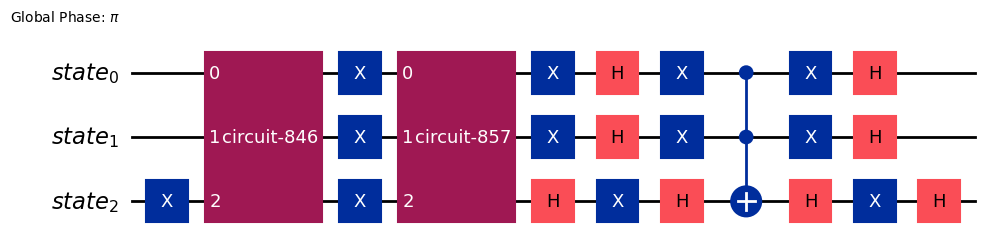

In [17]:
grover_op = GroverOperator(oracle)
grover_op.decompose().draw("mpl")

In [12]:
optimal_num_iterations = math.floor(
    math.pi / 4 * math.sqrt(2**grover_op.num_qubits / len(marked_states))
)

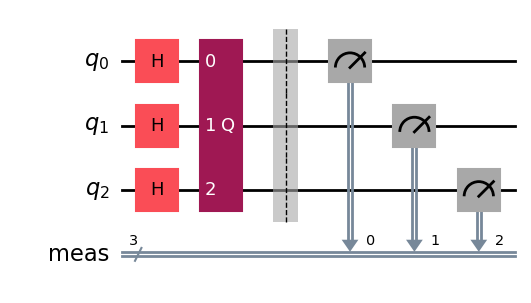

In [13]:
qc = QuantumCircuit(grover_op.num_qubits)
# Create even superposition of all basis states
qc.h(range(grover_op.num_qubits))
# Apply Grover operator the optimal number of times
qc.compose(grover_op.power(optimal_num_iterations), inplace=True)
# Measure all qubits
qc.measure_all()
qc.draw("mpl")

{'101': 15, '001': 5, '110': 11, '000': 20, '010': 17, '100': 450, '111': 20, '011': 486}


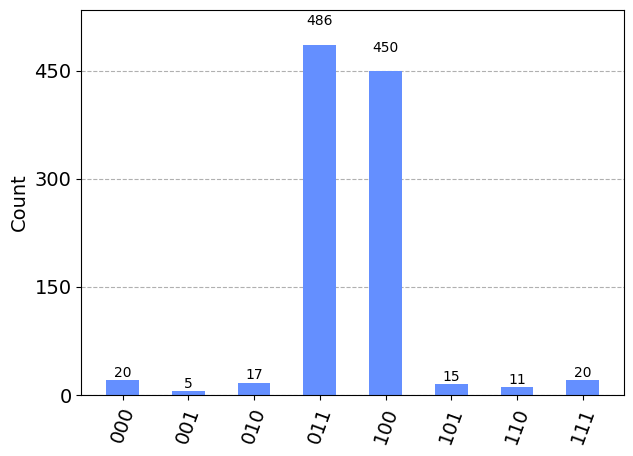

In [14]:
from qiskit import QuantumCircuit
from qiskit.providers.basic_provider import BasicProvider
from qiskit.visualization import plot_histogram
from qiskit import transpile
from qiskit.providers.fake_provider import GenericBackendV2
#from qiskit.visualization import plot_histogram
 
# Generate a 5-qubit simulated backend
backend = GenericBackendV2(num_qubits=5)
"""
# Alternative
from qiskit_ibm_runtime.fake_provider import FakeProvider
backend1 = FakeProvider().get_backend("fake_ourense")
 
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke
backend2 = FakeSherbrooke()"""
# Transpile the ideal circuit to a circuit that can be directly executed by the backend
transpiled_circuit = transpile(qc, backend)#transpiled_circuit = transpile(qc, backend=backend_simulator)
transpiled_circuit.draw('mpl')
 
# Run the transpiled circuit using the simulated backend
job = backend.run(transpiled_circuit)
counts = job.result().get_counts()
print(counts)
plot_histogram(counts)

{'100 100 100 110': 1, '011 011 010 011': 1, '100 101 100 100': 3, '110 110 110 110': 15, '000 100 100 100': 7, '011 011 111 011': 1, '100 110 100 100': 5, '011 011 011 111': 2, '100 100 100 100': 434, '001 001 001 001': 11, '011 011 011 001': 3, '100 100 100 000': 2, '010 011 011 011': 1, '011 111 011 011': 1, '000 000 000 000': 11, '111 111 111 111': 10, '010 010 010 010': 14, '101 101 101 101': 12, '100 100 100 101': 2, '111 101 111 111': 1, '011 001 011 011': 3, '011 011 011 011': 470, '100 100 000 100': 1, '100 000 100 100': 3, '101 100 100 100': 1, '011 011 001 011': 2, '100 100 110 100': 2, '011 001 111 011': 1, '001 011 011 011': 1, '110 100 100 100': 1, '100 100 101 100': 1, '111 011 011 011': 1}


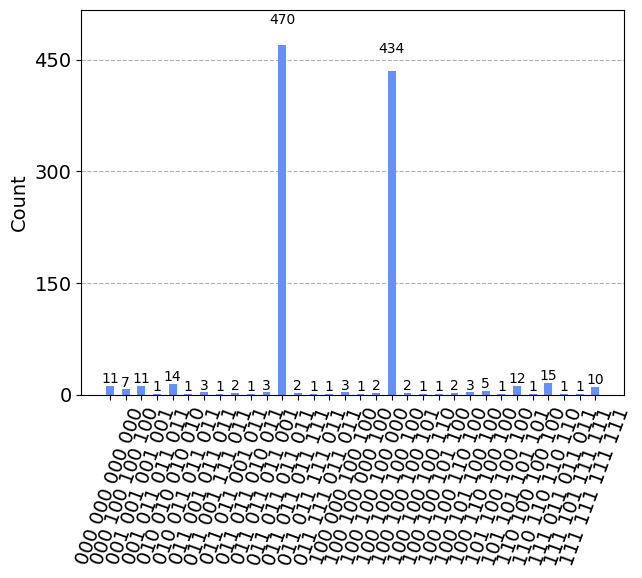

In [30]:
from qiskit import QuantumCircuit
from qiskit.providers.basic_provider import BasicProvider
from qiskit.visualization import plot_histogram
from qiskit import transpile
from qiskit.providers.fake_provider import GenericBackendV2
#from qiskit.visualization import plot_histogram
 
# Generate a 5-qubit simulated backend
backend = GenericBackendV2(num_qubits=5)
"""
# Alternative
from qiskit_ibm_runtime.fake_provider import FakeProvider
backend1 = FakeProvider().get_backend("fake_ourense")
 
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke
backend2 = FakeSherbrooke()"""
# Transpile the ideal circuit to a circuit that can be directly executed by the backend
transpiled_circuit = transpile(qc, backend)#transpiled_circuit = transpile(qc, backend=backend_simulator)
transpiled_circuit.draw('mpl')
 
# Run the transpiled circuit using the simulated backend
job = backend.run(transpiled_circuit)
counts = job.result().get_counts()
print(counts)
plot_histogram(counts)

In [22]:
from qiskit import QuantumCircuit
from qiskit.providers.basic_provider import BasicProvider
from qiskit.visualization import plot_histogram

#qc.measure_all()

from qiskit.providers.basic_provider import BasicProvider
backend = BasicProvider().get_backend("basic_simulator")
result = backend.run(qc).result()
 
"""
# Get the BasicSimulator backend from the BasicProvider
backend = BasicProvider().get_backend("basic_simulator")

# Simulate the quantum circuit
result = backend.run(qc).result()"""
# Alternative
from qiskit_ibm_runtime.fake_provider import FakeProvider
backend1 = FakeProvider().get_backend("fake_ourense")
 
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke
backend2 = FakeSherbrooke()

# Get counts from the result
counts = result.get_counts()

# Plot the histogram
plot_histogram(counts)

Traceback (most recent call last):
  Cell In[23], line 9
    result = backend.run(qc).result()
  File /opt/conda/lib/python3.10/site-packages/qiskit/providers/basic_provider/basic_simulator.py:499 in run
    job = BasicProviderJob(self, job_id, self._run_job(job_id, qobj))
  File /opt/conda/lib/python3.10/site-packages/qiskit/providers/basic_provider/basic_simulator.py:519 in _run_job
    result_list.append(self.run_experiment(experiment))
  File /opt/conda/lib/python3.10/site-packages/qiskit/providers/basic_provider/basic_simulator.py:695 in run_experiment
    raise BasicProviderError(err_msg.format(backend, operation.name))
BasicProviderError: 'basic_simulator encountered unrecognized operation "Q"'

Use %tb to get the full traceback.


In [9]:
backend_simulator = service.least_busy(operational=True, simulator=False)
backend_simulator.name

'ibm_kyoto'

In [10]:
# Initialize your session
sim_session = Session(backend=backend_simulator)
sim_sampler = Sampler(session=sim_session)

In [19]:
from qiskit import transpile
from qiskit.visualization import plot_histogram
# Assuming qc is your quantum circuit
# Transpile the circuit to match the target backend
transpiled_circuit = transpile(qc, backend=backend_simulator)

from qiskit.providers.basic_provider import BasicProvider
backend = BasicProvider().get_backend("ibmq_qasm_simulator")

job = backend.run(transpiled_circuit)
job = execute(qc, simulator, shots=1024)

# Wait for the job to finish
job_result = job.result()

# Get counts from the result
counts = job_result.get_counts()

# Plot the histogram
plot_histogram(counts)

Traceback (most recent call last):
  Cell In[19], line 8
    backend = BasicProvider().get_backend("ibmq_qasm_simulator")
  File /opt/conda/lib/python3.10/site-packages/qiskit/providers/basic_provider/basic_provider.py:48 in get_backend
    return super().get_backend(name=name, **kwargs)
  File /opt/conda/lib/python3.10/site-packages/qiskit/providers/provider.py:51 in get_backend
    backends = self.backends(name, **kwargs)
  File /opt/conda/lib/python3.10/site-packages/qiskit/providers/basic_provider/basic_provider.py:59 in backends
    raise QiskitBackendNotFoundError(
QiskitBackendNotFoundError: "The 'ibmq_qasm_simulator' backend is not installed in your system."

Use %tb to get the full traceback.


In [ ]:
from qiskit import transpile
from qiskit.visualization import plot_histogram
# Assuming qc is your quantum circuit
# Transpile the circuit to match the target backend
transpiled_circuit = transpile(qc, backend=backend_simulator)

# Run the transpiled circuit on the backend
job = backend_simulator.run(transpiled_circuit)

# Wait for the job to finish
job_result = job.result()

# Get counts from the result
counts = job_result.get_counts()

# Plot the histogram
plot_histogram(counts)

base_websocket_client.stream:INFO:2024-03-08 13:12:38,435: A websocket error occurred while streaming for job cqngpqjrpy7g008z3yag. Connection closed with 1006.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/websocket/_app.py", line 500, in setSock
    dispatcher.read(self.sock.sock, read, check)
  File "/opt/conda/lib/python3.10/site-packages/websocket/_app.py", line 112, in read
    if not read_callback():
  File "/opt/conda/lib/python3.10/site-packages/websocket/_app.py", line 523, in read
    raise e
  File "/opt/conda/lib/python3.10/site-packages/websocket/_app.py", line 515, in read
    op_code, frame = self.sock.recv_data_frame(True)
  File "/opt/conda/lib/python3.10/site-packages/websocket/_core.py", line 437, in recv_data_frame
    frame = self.recv_frame()
  File "/opt/conda/lib/python3.10/site-packages/websocket/_core.py", line 478, in recv_frame
    return self.frame_buffer.recv_frame()
  File "/opt/conda/lib/python3.10/site-packages/webs

In [22]:
sim_dist = sim_sampler.run(qc, shots=int(1e4)).result().quasi_dists[0]

Traceback (most recent call last):
  Cell In[22], line 1
    sim_dist = sim_sampler.run(qc, shots=int(1e4)).result().quasi_dists[0]
  File /opt/conda/lib/python3.10/site-packages/qiskit_ibm_runtime/sampler.py:234 in run
    return super().run(
  File /opt/conda/lib/python3.10/site-packages/qiskit/primitives/base/base_sampler.py:137 in run
    return self._run(
  File /opt/conda/lib/python3.10/site-packages/qiskit_ibm_runtime/sampler.py:263 in _run
    return self._run_primitive(
  File /opt/conda/lib/python3.10/site-packages/qiskit_ibm_runtime/base_primitive.py:334 in _run_primitive
    validate_isa_circuits(primitive_inputs["circuits"], self._backend.target)
  File /opt/conda/lib/python3.10/site-packages/qiskit_ibm_runtime/utils/utils.py:76 in validate_isa_circuits
    raise IBMInputValueError(
IBMInputValueError: 'The instruction h on qubits (0,) is not supported by the target system. Circuits that do not match the target hardware definition are no longer supported after March 4, 202

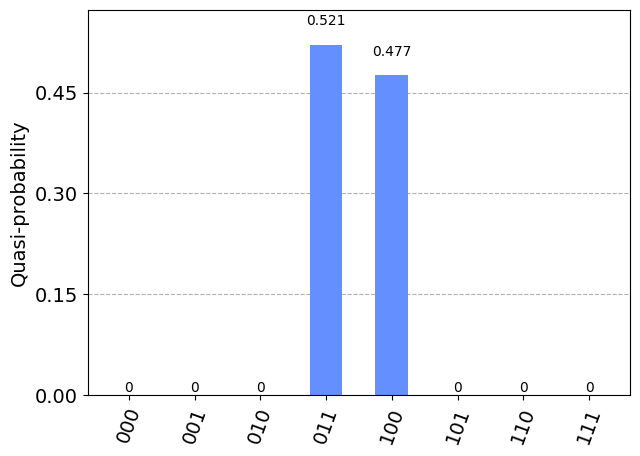

In [13]:
plot_distribution(sim_dist.binary_probabilities())

In [15]:
sim_session.close()

In [16]:
# Select the backend with the fewest number of jobs in the queue
backend = service.least_busy(simulator=False, operational=True)
backend.name

'ibmq_jakarta'

In [17]:
# Initialize your session
session = Session(backend=backend)

real_sampler = Sampler(session=session)

In [18]:
real_dist = real_sampler.run(qc, shots=int(1e4)).result().quasi_dists[0]

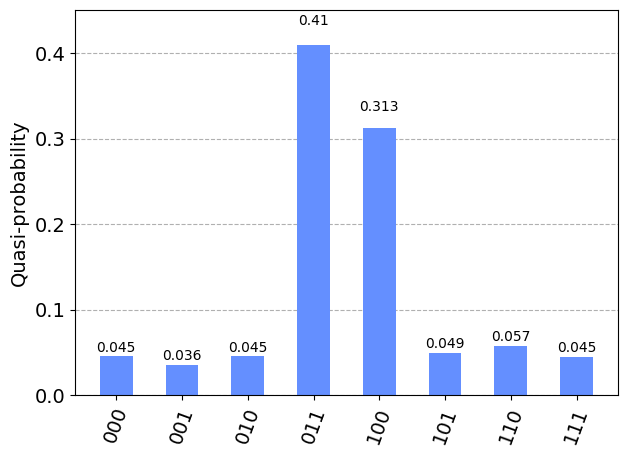

In [19]:
plot_distribution(real_dist.binary_probabilities())

In [20]:
# Close session
session.close()